# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [11]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values= "-999").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

dat.columns

Index(['AdultBodyMass', 'CranialCapacity', 'Diet_Invertebrates',
       'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds',
       'Diet_Plants', 'Diet_Other', 'HabitatBreadth', 'ActivityCycle',
       'ForagingStratum', 'GestationLength', 'LitterSize',
       'InterbirthInterval', 'HomeRange', 'PopulationDensity', 'SocialGrpSize',
       'Longevity', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'],
      dtype='object')

In [12]:

# drop variables with greater than 40% of observations missing
dat = dat.dropna(thresh=0.6*(len(dat)), axis=1)



print(f"Final DataFrame shape: {dat.shape}")

Final DataFrame shape: (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [13]:
# initialize KNN imputer for numeric and mode for categorical
knn_imputer = KNNImputer(n_neighbors=5)
mode_imputer = SimpleImputer(strategy='most_frequent')

# specify numerical columns and categorical columns
num_col = dat.select_dtypes(include=['float64']).columns
cat_col = dat.select_dtypes(include=['object']).columns

# impute for both numerical and categorical columns
dat[num_col] = pd.DataFrame(knn_imputer.fit_transform(dat[num_col]))
dat[cat_col] = pd.DataFrame(mode_imputer.fit_transform(dat[cat_col]))

# Check to make sure there are no NAs
dat.isna().sum()
# it worked!

AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [14]:
dat.head()

,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Dry,Humid,Montane,Subarid,Subhumid
0,78.0,yes,no,yes,yes,no,yes,no,1.0,2.0,3.0,1.000,0,1,1,0,1
1,1082.0,no,no,yes,no,no,yes,no,1.0,1.0,3.0,1.402,0,1,0,0,1
2,946.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,4.692,1,0,0,0,0
3,1180.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,1.010,1,1,1,0,1
4,1212.5,no,no,yes,no,no,yes,no,1.0,1.0,3.0,1.540,0,1,0,1,1


In [15]:
# Create a new column `nClimates` that combines the information of all five climate type variables
dat['nClimates'] = dat[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)

# Drop the original `Dry`, `Humid`,`Montane`,`Subarid` and `Subhumid` columns
cols_to_drop = ['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']
dat = dat.drop(columns=cols_to_drop, axis=1)

# Encode categorical variables
label_encoder = LabelEncoder()
for col in cat_col:
    dat[col] = label_encoder.fit_transform(dat[col])

dat.head()

,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,nClimates
0,78.0,1,0,1,1,0,1,0,1.0,2.0,3.0,1.000,3
1,1082.0,0,0,1,0,0,1,0,1.0,1.0,3.0,1.402,2
2,946.0,0,0,1,0,0,1,0,2.0,1.0,3.0,4.692,1
3,1180.0,0,0,1,0,0,1,0,2.0,1.0,3.0,1.010,4
4,1212.5,0,0,1,0,0,1,0,1.0,1.0,3.0,1.540,3


In [16]:
# Split the dataset into training and test sets
X = dat.drop('nClimates', axis=1)
y = dat['nClimates']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

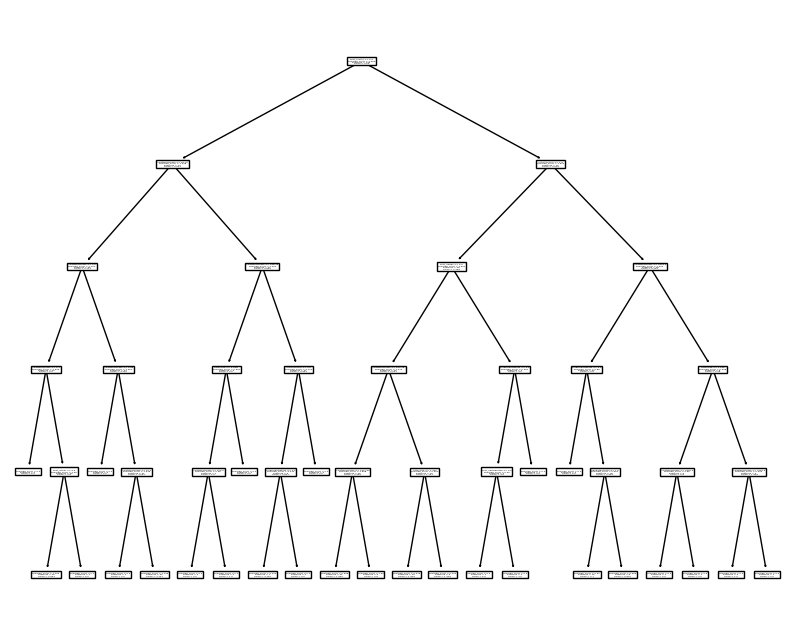

Mean squared error: 1.990


<Figure size 640x480 with 0 Axes>

In [20]:
# Train a `DecisionTreeRegressor`
# initialize classifier
dt = DecisionTreeRegressor(random_state=808, max_depth=5)

# train tree
dt.fit(X_train, y_train)

# make predictions 
y_pred = dt.predict(X_test)

# visualize the decision tree using `plot_tree`
plt.figure(figsize=(10,8))
plot_tree(dt, feature_names=X.columns)
plt.show()
# save plot so I can see nodes
plt.savefig('decision_tree.svg', format = 'svg')

# evaluate and print its performance using mse
dt_mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {dt_mse:.3f}")

In [19]:
dt.tree_.value[0]

array([[3.02013423]])

Based on the way this tree looks, what would you guess the most important variable to be?

Based on the way this tree looks, it seems like the `Diet_Plants` variable is the most important because it is at the root.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [ ]:
# define parameter grid
param_grid = {
    'max_features': ['sqrt', 6, None],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# initialize random forest regressor
rf = RandomForestRegressor()

# set up `GridSearchCV` with 5-fold cross-validation and mse
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# use grid search to train model
grid_search.fit(X_train, y_train)

# find the best estimator
best_rf = grid_search.best_estimator_

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mean squared error: 1.447


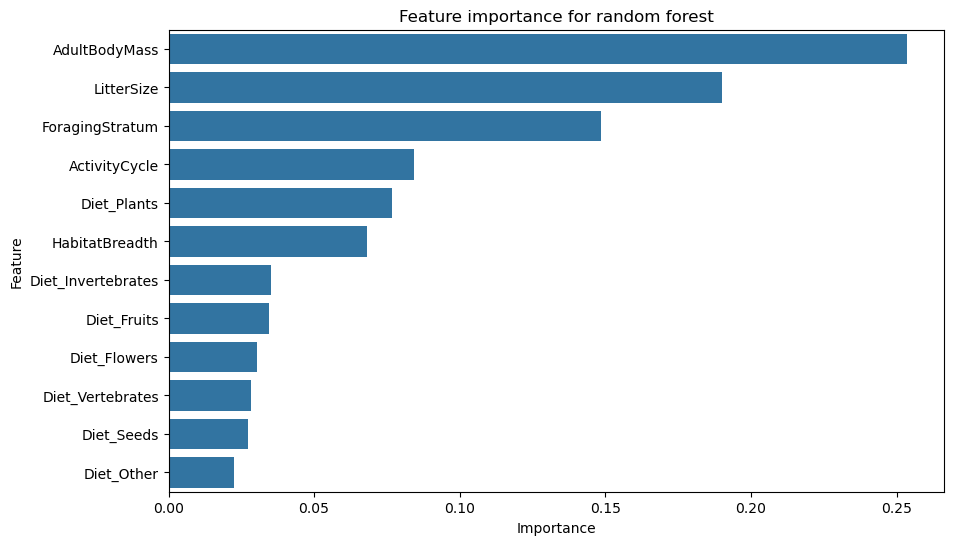

In [31]:
# use `best_rf` to generate predictions
best_rf_pred = best_rf.predict(X_test)

# print best set of parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# compute and print the mse to evaluate model performance
mse = mean_squared_error(y_test, best_rf_pred)
print(f"Mean squared error: {mse:.3f}")

# extract feature importance 
feature_importance = best_rf.feature_importances_

# visualize feature importance - put it into a dataframe to plot
importance_df = pd.DataFrame(zip(X_test.columns, feature_importance), columns = ['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10,6))
sns.barplot(y = importance_df['Feature'], x = importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance for random forest')
plt.show()


Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

Based on our mean squared error, we can deduce that the ensemble of trees performed better than the single tree. This is because our mean squared error for the ensemble of trees is about 0.5 lower than the mean squared error for the single tree. Our plot of feature importance for the random forest model shows us that `AdultBodyMass` and `LitterSize` have the most influence on species' climate adaptability. 